Call the necessary libraries.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Import Iris Dataset. Perform Clustering

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Saving figure classification_vs_clustering_plot


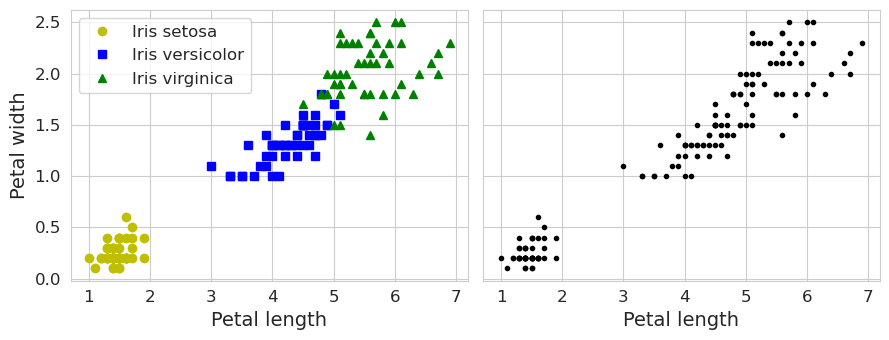

In [4]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

A Gaussian mixture model (explained below) can actually separate these clusters pretty well (using all 4 features: petal length & width, and sepal length & width).

In [5]:
from sklearn.mixture import GaussianMixture

In [6]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

Let's map each cluster to a class. Instead of hard coding the mapping (as is done in the book, for simplicity), we will pick the most common class for each cluster (using the scipy.stats.mode() function):

In [7]:
from scipy import stats
import numpy as np

mapping = {}
for class_id in np.unique(y):
    mode_result = stats.mode(y_pred[y==class_id])

    # Check if mode is a scalar or array
    if np.isscalar(mode_result.mode):
        mapping[mode_result.mode] = class_id
    else:
        mapping[mode_result.mode[0]] = class_id

mapping

{np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(0): np.int64(2)}

In [8]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

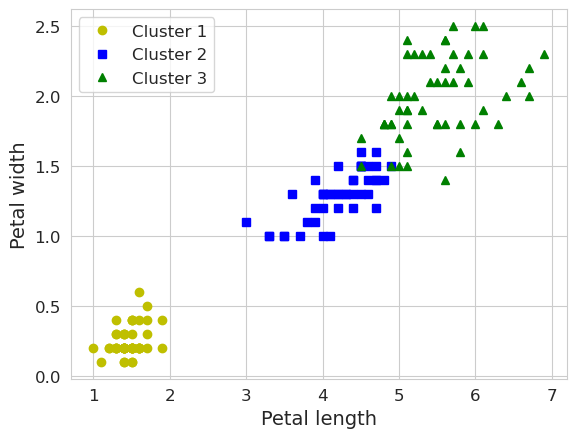

In [9]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [10]:
np.sum(y_pred==y)

np.int64(145)

In [11]:
np.sum(y_pred==y) / len(y_pred)

np.float64(0.9666666666666667)

# K-Means Clustering (create blobs and ﬁt k-means clustering to the dataset and perform prediction)

Creating some blobs

In [12]:
from sklearn.datasets import make_blobs

In [13]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [14]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Now let's plot them:

In [15]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


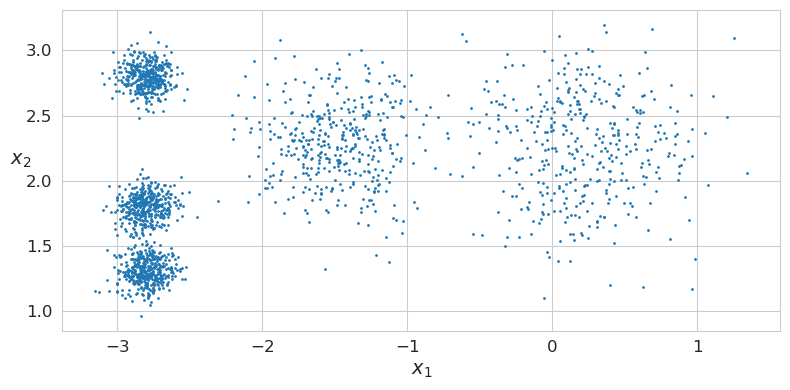

In [16]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

Fit and predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [18]:
from sklearn.cluster import KMeans

In [19]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the 5 clusters:

In [20]:
y_pred

array([2, 2, 4, ..., 1, 4, 2], dtype=int32)

In [21]:
y_pred is kmeans.labels_

True

And the following 5 centroids (i.e., cluster centers) were estimated:

In [22]:
kmeans.cluster_centers_

array([[-0.066884  ,  2.10378803],
       [-2.79290307,  2.79641063],
       [-2.80214068,  1.55162671],
       [-1.47468607,  2.28399066],
       [ 0.47042841,  2.41380533]])

Note that the KMeans instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the label of an instance is the index of the cluster that instance gets assigned to:

In [23]:
kmeans.labels_

array([2, 2, 4, ..., 1, 4, 2], dtype=int32)

Of course, we can predict the labels of new instances:

In [24]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 4, 1, 1], dtype=int32)

Decision Boundaries

Let's plot the model's decision boundaries. This gives us a Voronoi diagram:

In [26]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


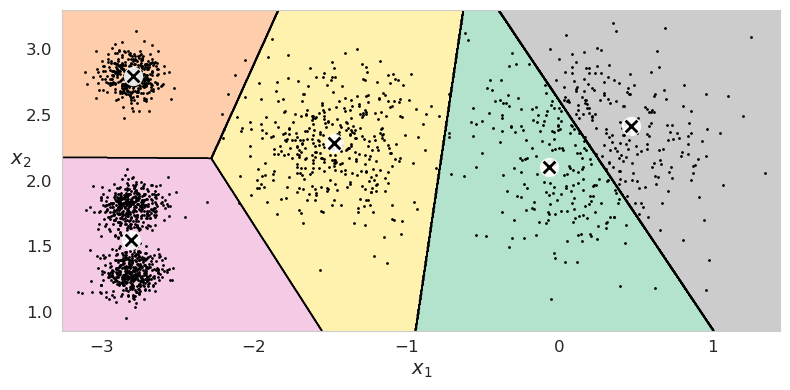

In [27]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

Hard Clustering vs Soft Clustering

Rather than arbitrarily choosing the closest cluster for each instance, which is called hard clustering, it might be better measure the distance of each instance to all 5 centroids. This is what the transform() method does:

In [28]:
kmeans.transform(X_new)

array([[0.12347236, 2.9042344 , 2.83778629, 1.50178217, 0.62652832],
       [3.06863967, 5.84739223, 5.81943941, 4.48368889, 2.56319474],
       [3.06697984, 0.29040966, 1.4618254 , 1.685008  , 3.51958769],
       [2.95975563, 0.36159148, 0.96879317, 1.54053323, 3.47149865]])

You can verify that this is indeed the Euclidian distance between each instance

List item
List item
and each centroid:

In [29]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[0.12347236, 2.9042344 , 2.83778629, 1.50178217, 0.62652832],
       [3.06863967, 5.84739223, 5.81943941, 4.48368889, 2.56319474],
       [3.06697984, 0.29040966, 1.4618254 , 1.685008  , 3.51958769],
       [2.95975563, 0.36159148, 0.96879317, 1.54053323, 3.47149865]])

# The K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:

First initialize  k  centroids randomly:  k  distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
Repeat until convergence (i.e., until the centroids stop moving):
Assign each instance to the closest centroid.
Update the centroids to be the mean of the instances that are assigned to them.

The KMeans class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set init="random", n_init=1and algorithm="full". These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [30]:
from sklearn.cluster import KMeans

kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(init='random', max_iter=3, n_clusters=5, n_init=1, random_state=0)

And let's plot this:

Saving figure kmeans_algorithm_plot


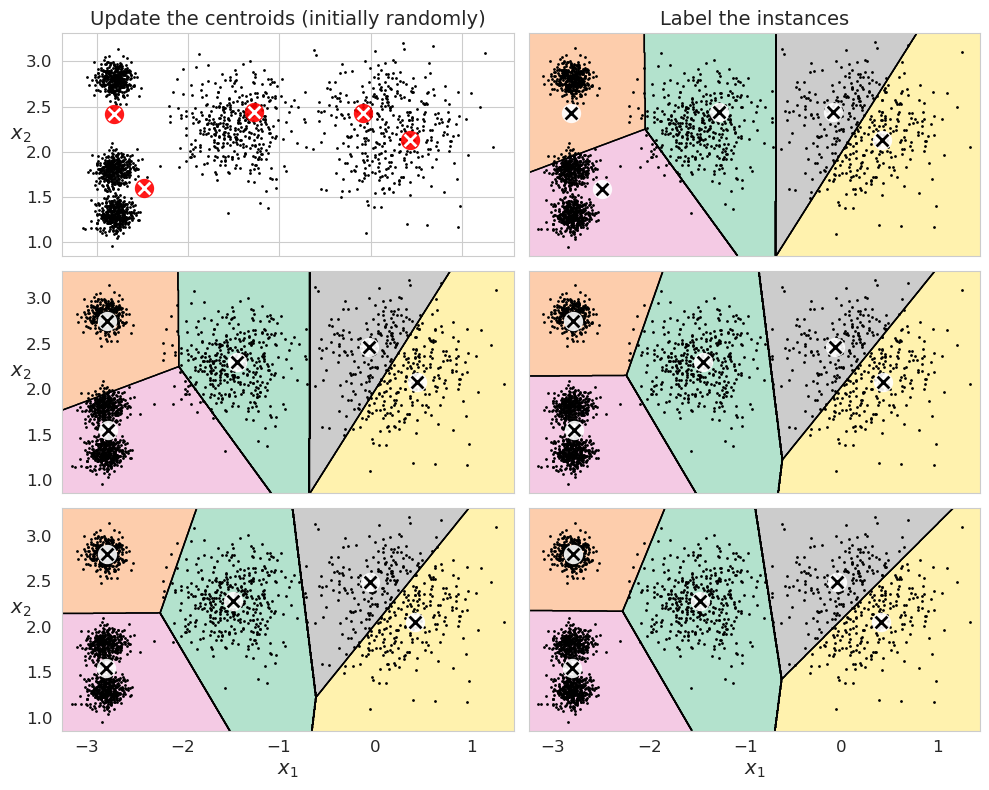

In [31]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

K-Means Variability

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [32]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


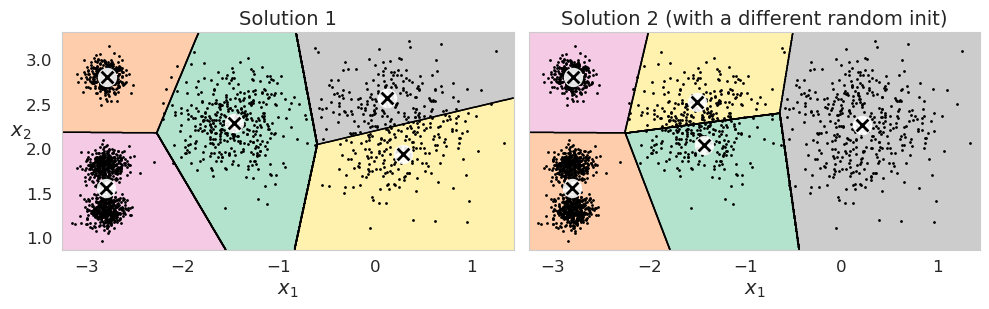

In [33]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="lloyd", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="lloyd", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

Inertia
To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the inertia metric:

In [34]:
kmeans.inertia_

224.0743312251571

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [35]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

np.float64(224.07433122515772)

The score() method returns the negative inertia. Why negative? Well, it is because a predictor's score() method must always respect the "greater is better" rule.

In [36]:
kmeans.score(X)

-224.07433122515712

# Multiple Initializations - Run K-Means algorithm multiple times with diﬀerent random initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [37]:
kmeans_rnd_init1.inertia_

219.58201503602282

In [38]:
kmeans_rnd_init2.inertia_

239.1922640341047

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the n_init hyperparameter, Scikit-Learn runs the original algorithm n_init times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets n_init=10.

In [39]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="lloyd", random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(init='random', n_clusters=5, n_init=10, random_state=2)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming  k=5 ).

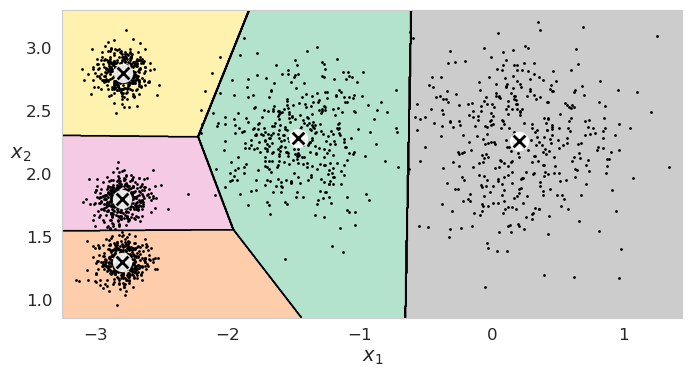

In [40]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

# Mini-Batch K-Means

In [41]:
from sklearn.cluster import MiniBatchKMeans

In [42]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [43]:
minibatch_kmeans.inertia_

211.6594510571261

If the dataset does not fit in memory, the simplest option is to use the memmap class, just like we did for incremental PCA in the previous chapter. First let's load MNIST:

Warning: since Scikit-Learn 0.24, fetch_openml() returns a Pandas DataFrame by default. To avoid this and keep the same code as in the book, we use as_frame=False.

In [44]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

Next, let's write it to a memmap:

In [46]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [47]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

If your data is so large that you cannot use memmap, things get more complicated. Let's start by writing a function to load the next batch (in real life, you would load the data from disk):

In [48]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Now we can train the model by feeding it one batch at a time. We also need to implement multiple initializations and keep the model with the lowest inertia:

In [49]:
np.random.seed(42)

In [50]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [51]:
best_kmeans.score(X)

-211.62123584033392

Mini-batch K-Means is much faster than regular K-Means:

In [52]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

5.47 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

The slowest run took 5.08 times longer than the fastest. This could mean that an intermediate result is being cached.
12.8 ms ± 7.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's much faster! However, its performance is often lower (higher inertia), and it keeps degrading as k increases. Let's plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means:

In [54]:
from timeit import timeit

In [55]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

Saving figure minibatch_kmeans_vs_kmeans


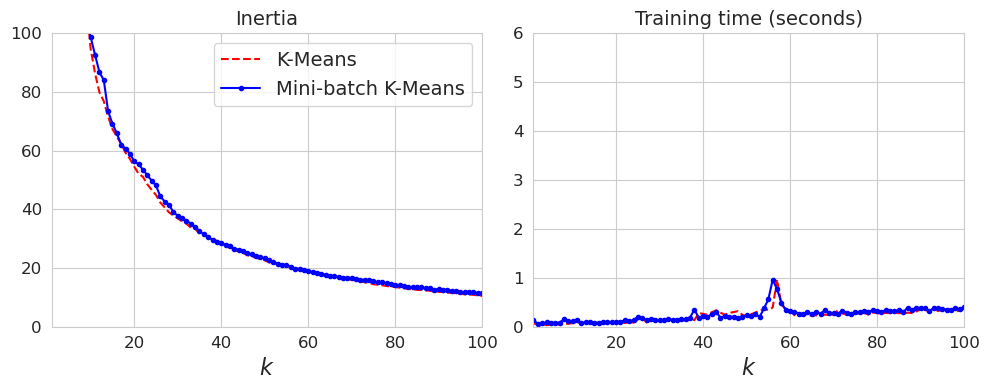

In [56]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

# Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5?

Saving figure bad_n_clusters_plot


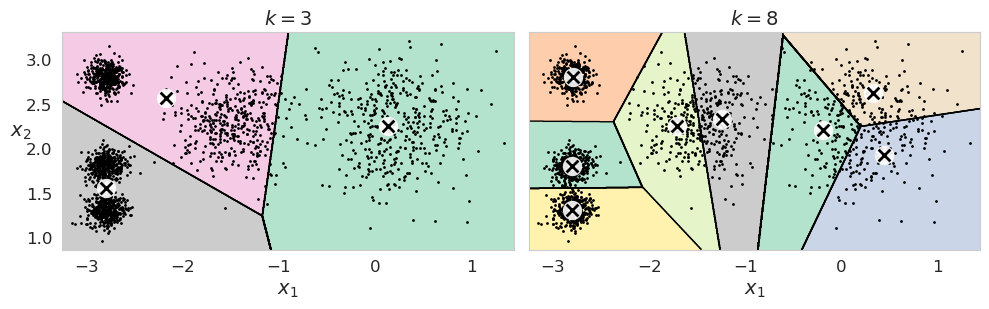

In [57]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [58]:
kmeans_k3.inertia_

653.216719002155

In [59]:
kmeans_k8.inertia_

127.13141880461839

No, we cannot simply take the value of  k  that minimizes the inertia, since it keeps getting lower as we increase  k . Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of  k  and analyze the resulting curve:

In [60]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


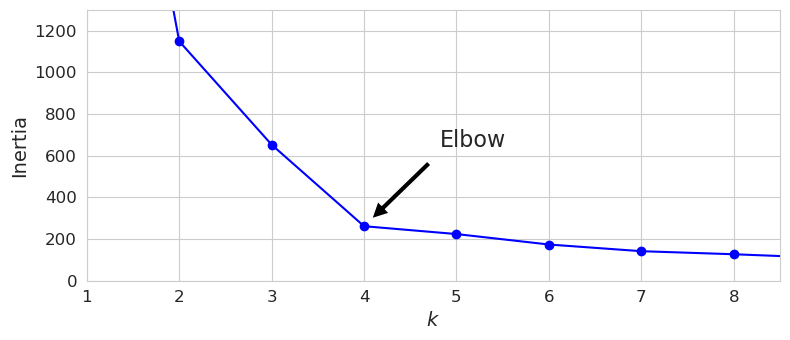

In [61]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

As you can see, there is an elbow at  k=4 , which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So  k=4  is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

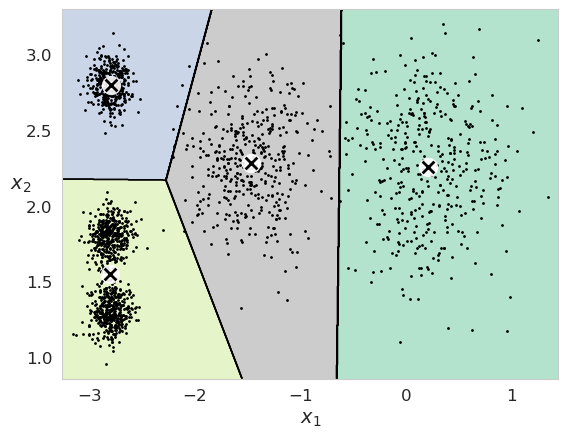

In [62]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Another approach is to look at the silhouette score, which is the mean silhouette coefficient over all the instances. An instance's silhouette coefficient is equal to  (b−a)/max(a,b)  where  a  is the mean distance to the other instances in the same cluster (it is the mean intra-cluster distance), and  b  is the mean nearest-cluster distance, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes  b , excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of  k :

In [63]:
from sklearn.metrics import silhouette_score

In [64]:
silhouette_score(X, kmeans.labels_)

np.float64(0.6267891051050735)

In [65]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


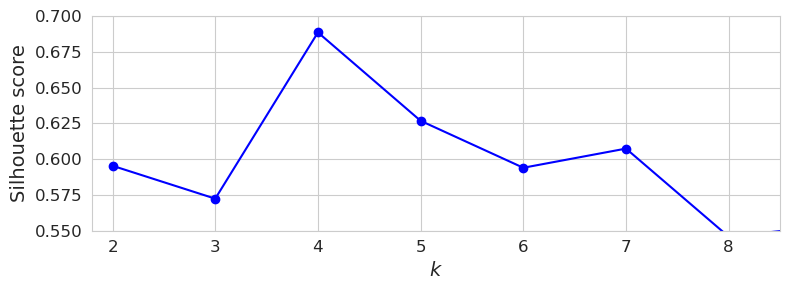

In [66]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that  k=4  is a very good choice, but it also underlines the fact that  k=5  is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a silhouette diagram:

Saving figure silhouette_analysis_plot


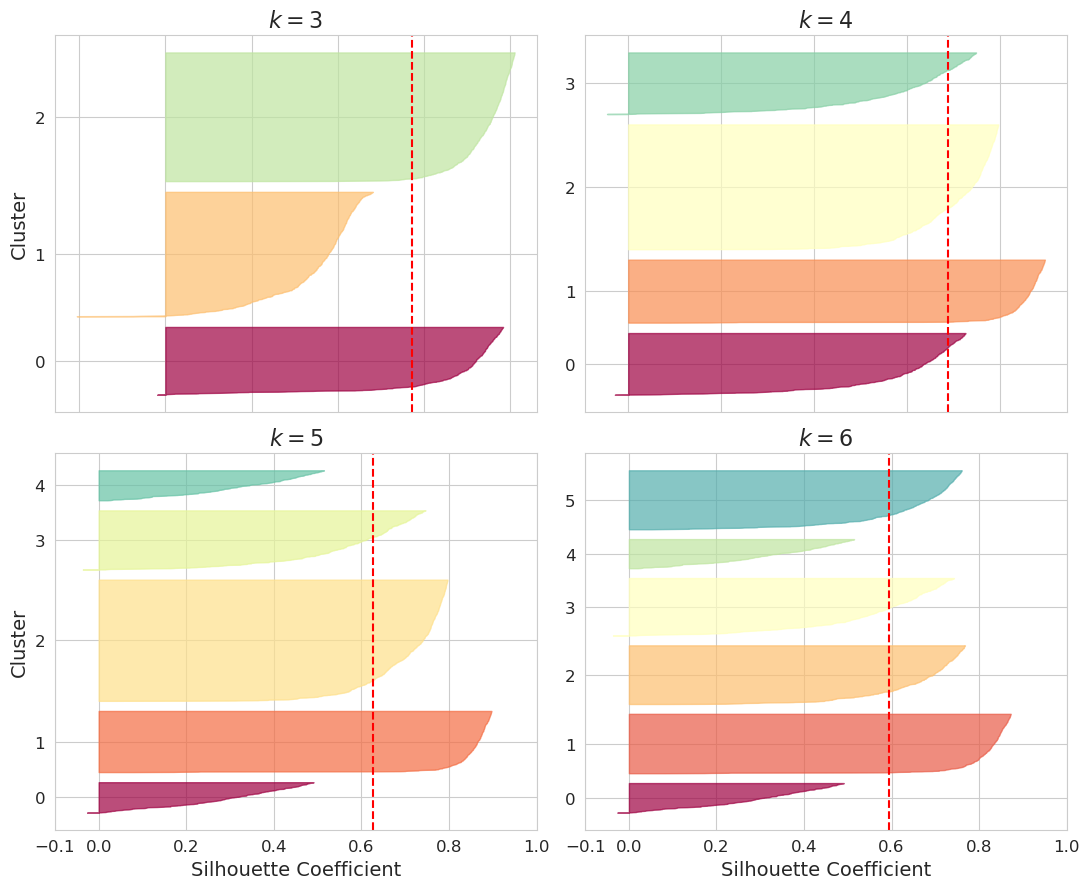

In [67]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

As you can see,  k=5  looks like the best option here, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.

# Limits of K-Means

In [68]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [69]:
plot_clusters(X)

In [70]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

Saving figure bad_kmeans_plot


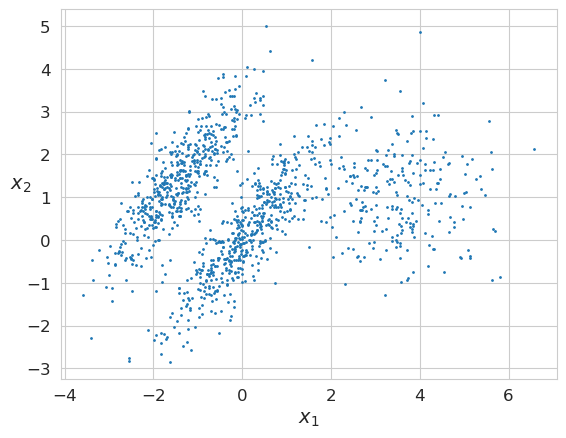

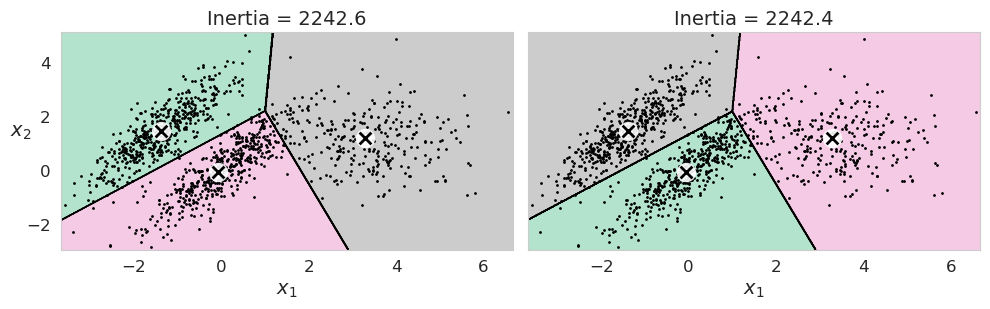

In [71]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

# LAB 6 ASSIGNMENT

Apply K-Means Clustering on the California Housing Dataset based on longitude, latitude and median_income

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Load the California Housing dataset
print("Loading California Housing dataset...")
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df['MedHouseVal'] = california.target

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Select features for clustering
features = ['Longitude', 'Latitude', 'MedInc']
X = df[features].copy()

print(f"\nSelected features for clustering: {features}")
print("\nFeature statistics:")
print(X.describe())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nFeatures standardized successfully!")
print("✓ Data loading and preparation complete!")


Loading California Housing dataset...
Dataset shape: (20640, 9)

First few rows:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  

Selected features for clustering: ['Longitude', 'Latitude', 'MedInc']

Feature statistics:
          Longitude      Latitude        MedInc
count  20640.000000  20640.000000  20640.000000
mean    -119.569704     35.631861      3.870671
std        2.003532      2.135952      1.899822
min     -1

CELL 2: Optimal Cluster Selection

Calculating optimal number of clusters using Elbow Method and Silhouette Score...

Cluster Evaluation Metrics:
 k      Inertia  Silhouette Score
 2 26860.980369          0.548225
 3 18987.158802          0.517727
 4 14547.511703          0.435079
 5 11838.381938          0.386963
 6 10039.010938          0.398465
 7  8732.358453          0.370474
 8  7713.683413          0.352519
 9  7019.713439          0.356154
10  6416.675927          0.342536


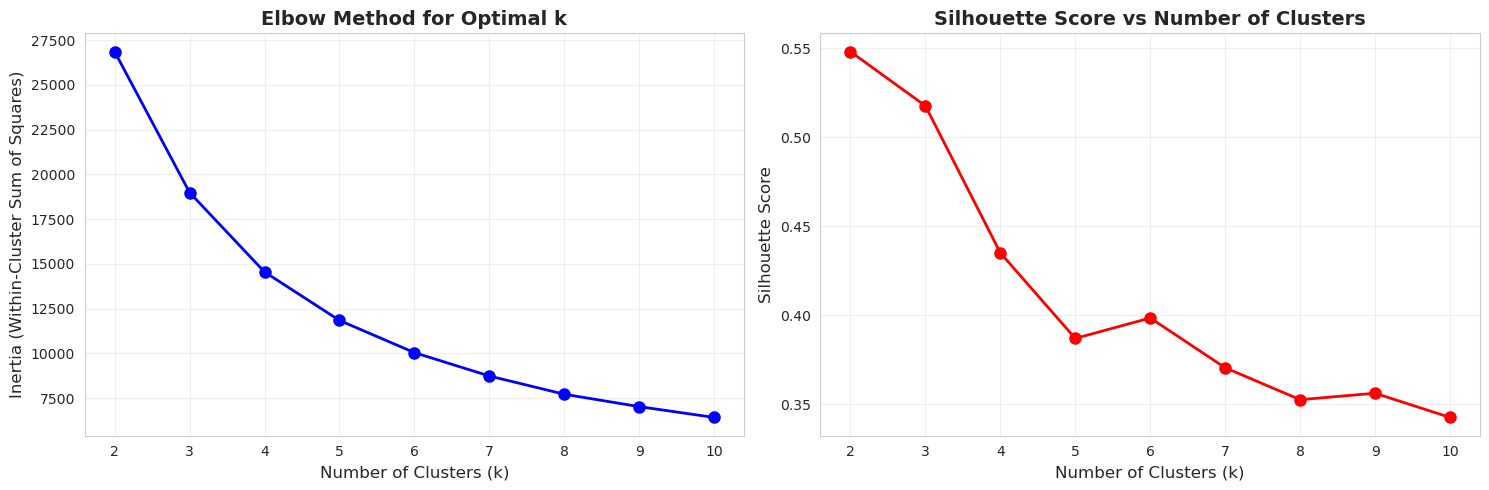


✓ Optimal cluster analysis complete!


In [4]:
print("Calculating optimal number of clusters using Elbow Method and Silhouette Score...")

inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Display results
results_df = pd.DataFrame({
    'k': list(K_range),
    'Inertia': inertias,
    'Silhouette Score': silhouette_scores
})
print("\nCluster Evaluation Metrics:")
print(results_df.to_string(index=False))

# Plot Elbow Method and Silhouette Scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Optimal cluster analysis complete!")


CELL 3: K-Means Clustering

In [5]:
#Apply K-Means with optimal k (you can adjust this value)
optimal_k = 5
print(f"Applying K-Means clustering with k={optimal_k} clusters...")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Calculate performance metrics
silhouette_avg = silhouette_score(X_scaled, df['Cluster'])

print(f"\n✓ Clustering complete!")
print(f"\nPerformance Metrics:")
print(f"  - Number of clusters: {optimal_k}")
print(f"  - Silhouette Score: {silhouette_avg:.4f}")
print(f"  - Inertia: {kmeans.inertia_:.2f}")

# Cluster statistics
print("\n" + "="*70)
print("CLUSTER STATISTICS")
print("="*70)

cluster_stats = df.groupby('Cluster')[features + ['MedHouseVal']].mean()
print("\nMean values per cluster:")
print(cluster_stats)

print("\nCluster Sizes:")
cluster_sizes = df['Cluster'].value_counts().sort_index()
print(cluster_sizes)
print(f"\nPercentage distribution:")
for cluster in range(optimal_k):
    pct = (cluster_sizes[cluster] / len(df)) * 100
    print(f"  Cluster {cluster}: {pct:.2f}%")

print("\n✓ Clustering analysis complete!")

Applying K-Means clustering with k=5 clusters...

✓ Clustering complete!

Performance Metrics:
  - Number of clusters: 5
  - Silhouette Score: 0.3870
  - Inertia: 11838.38

CLUSTER STATISTICS

Mean values per cluster:
          Longitude   Latitude     MedInc  MedHouseVal
Cluster                                               
0       -117.983992  33.992260   2.701510     1.648604
1       -121.928668  37.705198   5.397651     2.803007
2       -118.025386  33.872812   5.179153     2.640310
3       -119.135446  34.807690  10.289102     4.624667
4       -121.601062  38.106236   2.734424     1.447890

Cluster Sizes:
Cluster
0    6969
1    3011
2    4534
3     606
4    5520
Name: count, dtype: int64

Percentage distribution:
  Cluster 0: 33.76%
  Cluster 1: 14.59%
  Cluster 2: 21.97%
  Cluster 3: 2.94%
  Cluster 4: 26.74%

✓ Clustering analysis complete!


Rich Visualizations

In [6]:
print("Generating visualizations...")

# Create a colormap for consistent cluster colors across plots
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))

# Plot 1: Clusters on geographic map
fig1, ax1 = plt.subplots(figsize=(10, 8))
scatter = ax1.scatter(df['Longitude'], df['Latitude'],
                      c=df['Cluster'], cmap='viridis',
                      alpha=0.6, s=20, edgecolors='none')
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
ax1.set_title('K-Means Clusters on California Map', fontsize=14, fontweight='bold')
cbar1 = plt.colorbar(scatter, ax=ax1, label='Cluster')
cbar1.set_ticks(range(optimal_k))
plt.tight_layout()
plt.savefig('clusters_map.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: clusters_map.png")

# Plot 2: Median Income distribution
fig2, ax2 = plt.subplots(figsize=(10, 8))
scatter2 = ax2.scatter(df['Longitude'], df['Latitude'],
                       c=df['MedInc'], cmap='coolwarm',
                       alpha=0.6, s=20, edgecolors='none')
ax2.set_xlabel('Longitude', fontsize=12)
ax2.set_ylabel('Latitude', fontsize=12)
ax2.set_title('Median Income Distribution', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='Median Income (×$10k)')
plt.tight_layout()
plt.savefig('income_distribution.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: income_distribution.png")

# Plot 3: Longitude vs Median Income by cluster
fig3, ax3 = plt.subplots(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    ax3.scatter(cluster_data['Longitude'], cluster_data['MedInc'],
                label=f'Cluster {cluster}', alpha=0.6, s=20,
                color=colors[cluster], edgecolors='none')
ax3.set_xlabel('Longitude', fontsize=12)
ax3.set_ylabel('Median Income (×$10k)', fontsize=12)
ax3.set_title('Longitude vs Median Income by Cluster', fontsize=14, fontweight='bold')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('longitude_vs_income.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: longitude_vs_income.png")

# Plot 4: Cluster size distribution
fig4, ax4 = plt.subplots(figsize=(10, 8))
cluster_counts = df['Cluster'].value_counts().sort_index()
bars = ax4.bar(cluster_counts.index, cluster_counts.values,
               color=colors, edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Cluster', fontsize=12)
ax4.set_ylabel('Number of Data Points', fontsize=12)
ax4.set_title('Distribution of Data Points Across Clusters', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_xticks(range(optimal_k))

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: cluster_distribution.png")

print("✓ All visualizations saved successfully!")

Generating visualizations...
✓ Saved: clusters_map.png
✓ Saved: income_distribution.png
✓ Saved: longitude_vs_income.png
✓ Saved: cluster_distribution.png
✓ All visualizations saved successfully!


Detailed Analysis

In [76]:
print("="*70)
print("DETAILED CLUSTER CHARACTERISTICS ANALYSIS")
print("="*70)

for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]

    print(f"\n{'─'*70}")
    print(f"CLUSTER {cluster}")
    print(f"{'─'*70}")

    # Size and proportion
    cluster_size = len(cluster_data)
    cluster_pct = (cluster_size / len(df)) * 100
    print(f"Size: {cluster_size:,} houses ({cluster_pct:.2f}% of total)")

    # Geographic characteristics
    print(f"\nGeographic Characteristics:")
    print(f"  • Longitude: {cluster_data['Longitude'].mean():.4f} "
          f"(range: {cluster_data['Longitude'].min():.4f} to {cluster_data['Longitude'].max():.4f})")
    print(f"  • Latitude:  {cluster_data['Latitude'].mean():.4f} "
          f"(range: {cluster_data['Latitude'].min():.4f} to {cluster_data['Latitude'].max():.4f})")

    # Economic characteristics
    print(f"\nEconomic Characteristics:")
    print(f"  • Median Income:  ${cluster_data['MedInc'].mean():.4f} × 10k "
          f"= ${cluster_data['MedInc'].mean()*10000:,.0f}")
    print(f"  • House Value:    ${cluster_data['MedHouseVal'].mean():.4f} × 100k "
          f"= ${cluster_data['MedHouseVal'].mean()*100000:,.0f}")

    # Additional statistics
    print(f"\nAdditional Statistics:")
    print(f"  • Avg Age of Houses: {cluster_data['HouseAge'].mean():.2f} years")
    print(f"  • Avg Rooms per House: {cluster_data['AveRooms'].mean():.2f}")
    print(f"  • Avg Population: {cluster_data['Population'].mean():.0f}")

print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}")

# Find interesting clusters
highest_income_cluster = df.groupby('Cluster')['MedInc'].mean().idxmax()
lowest_income_cluster = df.groupby('Cluster')['MedInc'].mean().idxmin()
highest_value_cluster = df.groupby('Cluster')['MedHouseVal'].mean().idxmax()

print(f"\nKey Findings:")
print(f"  • Highest Income Cluster: Cluster {highest_income_cluster} "
      f"(${df[df['Cluster']==highest_income_cluster]['MedInc'].mean()*10000:,.0f} median income)")
print(f"  • Lowest Income Cluster: Cluster {lowest_income_cluster} "
      f"(${df[df['Cluster']==lowest_income_cluster]['MedInc'].mean()*10000:,.0f} median income)")
print(f"  • Highest House Value Cluster: Cluster {highest_value_cluster} "
      f"(${df[df['Cluster']==highest_value_cluster]['MedHouseVal'].mean()*100000:,.0f} avg value)")

print("\n✓ Detailed analysis complete!")
print("\n" + "="*70)
print("K-MEANS CLUSTERING ANALYSIS FINISHED")
print("="*70)

DETAILED CLUSTER CHARACTERISTICS ANALYSIS

──────────────────────────────────────────────────────────────────────
CLUSTER 0
──────────────────────────────────────────────────────────────────────
Size: 6,969 houses (33.76% of total)

Geographic Characteristics:
  • Longitude: -117.9840 (range: -120.6800 to -114.3100)
  • Latitude:  33.9923 (range: 32.5400 to 37.3700)

Economic Characteristics:
  • Median Income:  $2.7015 × 10k = $27,015
  • House Value:    $1.6486 × 100k = $164,860

Additional Statistics:
  • Avg Age of Houses: 29.86 years
  • Avg Rooms per House: 4.59
  • Avg Population: 1541

──────────────────────────────────────────────────────────────────────
CLUSTER 1
──────────────────────────────────────────────────────────────────────
Size: 3,011 houses (14.59% of total)

Geographic Characteristics:
  • Longitude: -121.9287 (range: -124.1700 to -118.9800)
  • Latitude:  37.7052 (range: 35.1300 to 40.9400)

Economic Characteristics:
  • Median Income:  $5.3977 × 10k = $53,977
  

# Comparison with Other Clustering Algorithms


COMPARING CLUSTERING ALGORITHMS

1. K-MEANS CLUSTERING
--------------------------------------------------
Number of clusters: 5
Silhouette Score: 0.3870
Davies-Bouldin Index: 0.8787 (lower is better)
Calinski-Harabasz Score: 21823.83 (higher is better)
Computation Time: 0.0002 seconds

2. DBSCAN (Density-Based Spatial Clustering)
--------------------------------------------------
Number of clusters: 5
Number of noise points: 804 (3.90%)
Silhouette Score: -0.0621 (non-noise points)
Davies-Bouldin Index: 0.5620
Calinski-Harabasz Score: 365.82
Computation Time: 1.2388 seconds

3. HIERARCHICAL CLUSTERING (Agglomerative)
--------------------------------------------------
Number of clusters: 5
Silhouette Score: 0.3848
Davies-Bouldin Index: 0.8372
Calinski-Harabasz Score: 18858.27
Computation Time: 30.8138 seconds

PERFORMANCE COMPARISON TABLE


   Algorithm       Clusters Silhouette Davies-Bouldin Calinski-Harabasz Time (sec)
     K-Means              5     0.3870         0.8787          218

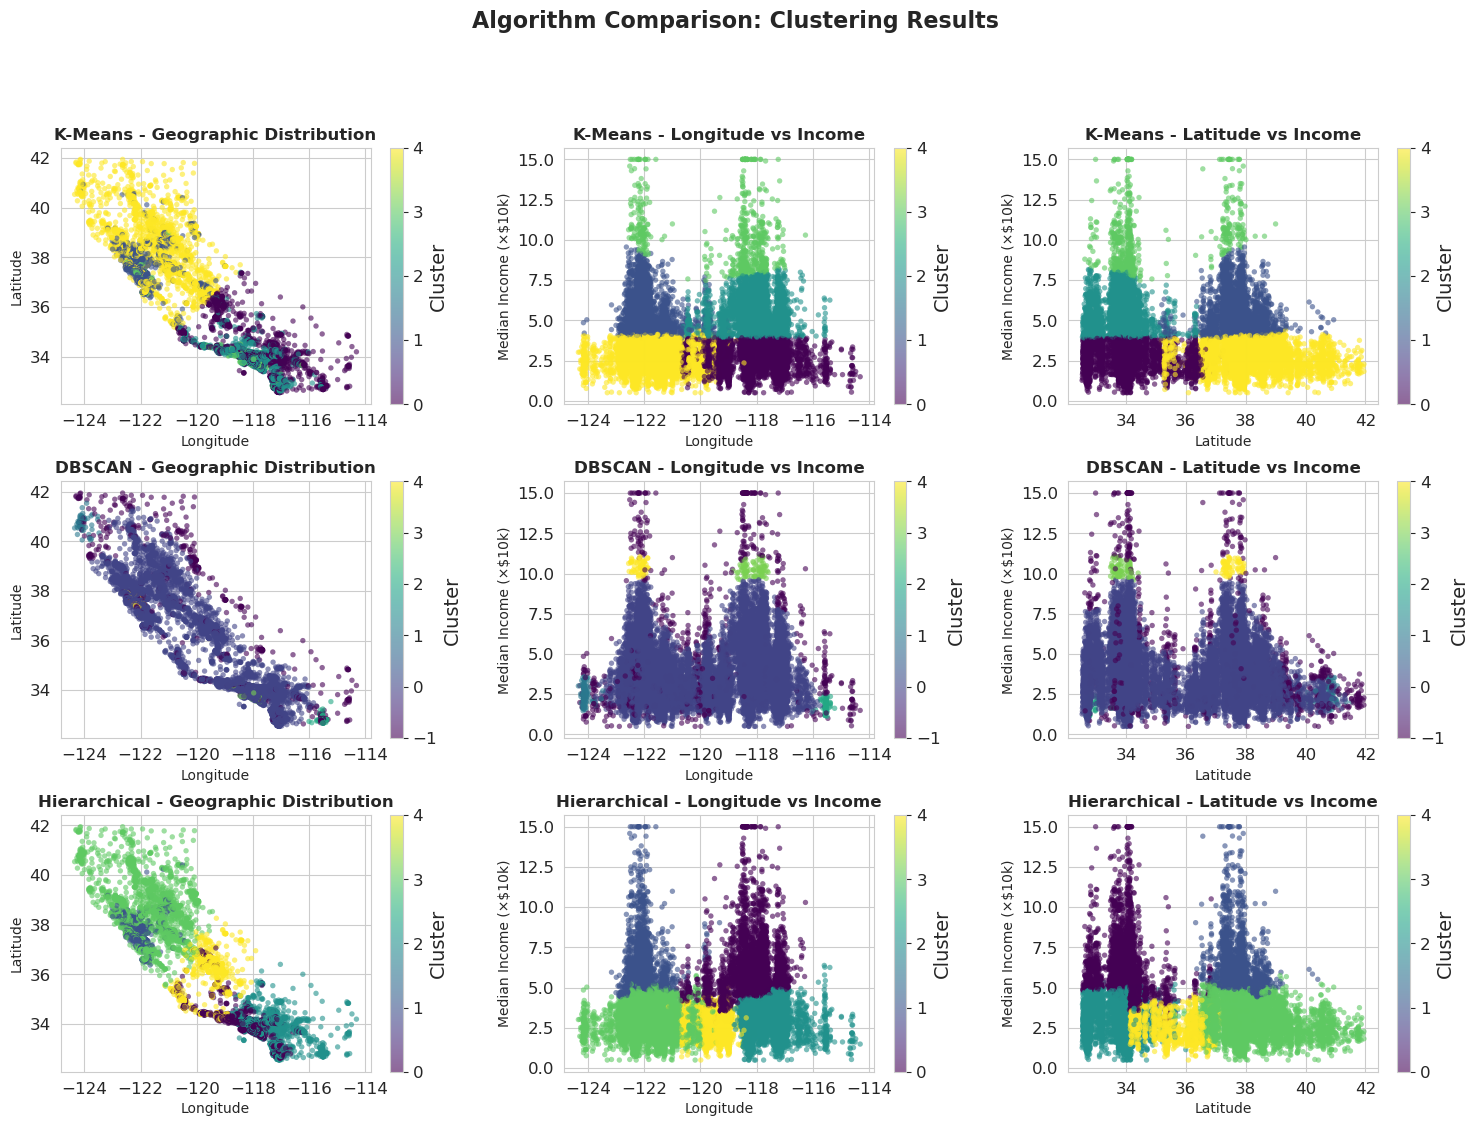

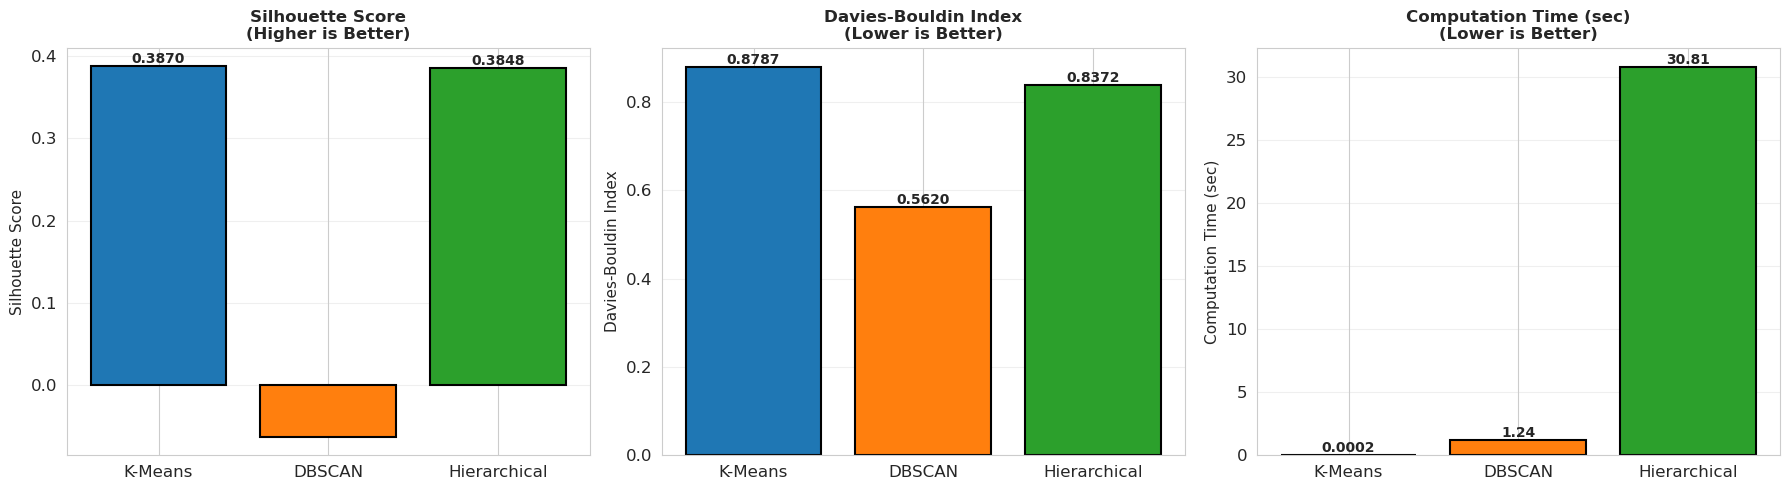


ALGORITHM COMPARISON - FINAL VERDICT

📊 STRENGTHS & WEAKNESSES:

K-MEANS:
  ✓ Strengths:
    • Fast and efficient for large datasets
    • Works well with spherical clusters
    • Easy to interpret and implement
    • Consistent results with good initialization
  ✗ Weaknesses:
    • Requires pre-specified number of clusters
    • Assumes clusters are spherical and equally sized
    • Sensitive to outliers

DBSCAN:
  ✓ Strengths:
    • Can find arbitrarily shaped clusters
    • Automatically identifies outliers (noise points)
    • Doesn't require pre-specified number of clusters
  ✗ Weaknesses:
    • Sensitive to parameter selection (eps, min_samples)
    • Struggles with varying density clusters
    • Identified 804 noise points (3.90% of data)

HIERARCHICAL:
  ✓ Strengths:
    • Provides dendrogram for cluster visualization
    • No need to specify clusters initially (can be cut at any level)
    • Deterministic results
  ✗ Weaknesses:
    • Computationally expensive for large datas

In [77]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import time

print("="*70)
print("COMPARING CLUSTERING ALGORITHMS")
print("="*70)

# Dictionary to store results
clustering_results = {}

# ---- 1. K-Means (Already computed) ----
print("\n1. K-MEANS CLUSTERING")
print("-" * 50)
start_time = time.time()
kmeans_labels = df['Cluster'].values
kmeans_time = time.time() - start_time

clustering_results['K-Means'] = {
    'labels': kmeans_labels,
    'n_clusters': len(np.unique(kmeans_labels)),
    'silhouette': silhouette_score(X_scaled, kmeans_labels),
    'davies_bouldin': davies_bouldin_score(X_scaled, kmeans_labels),
    'calinski_harabasz': calinski_harabasz_score(X_scaled, kmeans_labels),
    'time': kmeans_time
}

print(f"Number of clusters: {clustering_results['K-Means']['n_clusters']}")
print(f"Silhouette Score: {clustering_results['K-Means']['silhouette']:.4f}")
print(f"Davies-Bouldin Index: {clustering_results['K-Means']['davies_bouldin']:.4f} (lower is better)")
print(f"Calinski-Harabasz Score: {clustering_results['K-Means']['calinski_harabasz']:.2f} (higher is better)")
print(f"Computation Time: {clustering_results['K-Means']['time']:.4f} seconds")

# ---- 2. DBSCAN ----
print("\n2. DBSCAN (Density-Based Spatial Clustering)")
print("-" * 50)
start_time = time.time()
dbscan = DBSCAN(eps=0.3, min_samples=50)
dbscan_labels = dbscan.fit_predict(X_scaled)
dbscan_time = time.time() - start_time

# Count clusters (excluding noise points labeled as -1)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.2f}%)")

# Calculate metrics only for non-noise points
if n_clusters_dbscan > 1:
    non_noise_mask = dbscan_labels != -1
    if sum(non_noise_mask) > 0:
        clustering_results['DBSCAN'] = {
            'labels': dbscan_labels,
            'n_clusters': n_clusters_dbscan,
            'n_noise': n_noise,
            'silhouette': silhouette_score(X_scaled[non_noise_mask], dbscan_labels[non_noise_mask]),
            'davies_bouldin': davies_bouldin_score(X_scaled[non_noise_mask], dbscan_labels[non_noise_mask]),
            'calinski_harabasz': calinski_harabasz_score(X_scaled[non_noise_mask], dbscan_labels[non_noise_mask]),
            'time': dbscan_time
        }
        print(f"Silhouette Score: {clustering_results['DBSCAN']['silhouette']:.4f} (non-noise points)")
        print(f"Davies-Bouldin Index: {clustering_results['DBSCAN']['davies_bouldin']:.4f}")
        print(f"Calinski-Harabasz Score: {clustering_results['DBSCAN']['calinski_harabasz']:.2f}")
else:
    clustering_results['DBSCAN'] = {
        'labels': dbscan_labels,
        'n_clusters': n_clusters_dbscan,
        'n_noise': n_noise,
        'time': dbscan_time
    }
    print("Note: Not enough clusters formed for metric calculation")

print(f"Computation Time: {dbscan_time:.4f} seconds")

# ---- 3. Hierarchical Clustering (Agglomerative) ----
print("\n3. HIERARCHICAL CLUSTERING (Agglomerative)")
print("-" * 50)
start_time = time.time()
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)
hierarchical_time = time.time() - start_time

clustering_results['Hierarchical'] = {
    'labels': hierarchical_labels,
    'n_clusters': len(np.unique(hierarchical_labels)),
    'silhouette': silhouette_score(X_scaled, hierarchical_labels),
    'davies_bouldin': davies_bouldin_score(X_scaled, hierarchical_labels),
    'calinski_harabasz': calinski_harabasz_score(X_scaled, hierarchical_labels),
    'time': hierarchical_time
}

print(f"Number of clusters: {clustering_results['Hierarchical']['n_clusters']}")
print(f"Silhouette Score: {clustering_results['Hierarchical']['silhouette']:.4f}")
print(f"Davies-Bouldin Index: {clustering_results['Hierarchical']['davies_bouldin']:.4f}")
print(f"Calinski-Harabasz Score: {clustering_results['Hierarchical']['calinski_harabasz']:.2f}")
print(f"Computation Time: {hierarchical_time:.4f} seconds")

# ---- Comparison Table ----
print("\n" + "="*70)
print("PERFORMANCE COMPARISON TABLE")
print("="*70)

comparison_df = pd.DataFrame({
    'Algorithm': ['K-Means', 'DBSCAN', 'Hierarchical'],
    'Clusters': [
        clustering_results['K-Means']['n_clusters'],
        f"{clustering_results['DBSCAN']['n_clusters']} (+{clustering_results['DBSCAN']['n_noise']} noise)",
        clustering_results['Hierarchical']['n_clusters']
    ],
    'Silhouette': [
        f"{clustering_results['K-Means']['silhouette']:.4f}",
        f"{clustering_results['DBSCAN']['silhouette']:.4f}" if 'silhouette' in clustering_results['DBSCAN'] else 'N/A',
        f"{clustering_results['Hierarchical']['silhouette']:.4f}"
    ],
    'Davies-Bouldin': [
        f"{clustering_results['K-Means']['davies_bouldin']:.4f}",
        f"{clustering_results['DBSCAN']['davies_bouldin']:.4f}" if 'davies_bouldin' in clustering_results['DBSCAN'] else 'N/A',
        f"{clustering_results['Hierarchical']['davies_bouldin']:.4f}"
    ],
    'Calinski-Harabasz': [
        f"{clustering_results['K-Means']['calinski_harabasz']:.2f}",
        f"{clustering_results['DBSCAN']['calinski_harabasz']:.2f}" if 'calinski_harabasz' in clustering_results['DBSCAN'] else 'N/A',
        f"{clustering_results['Hierarchical']['calinski_harabasz']:.2f}"
    ],
    'Time (sec)': [
        f"{clustering_results['K-Means']['time']:.4f}",
        f"{clustering_results['DBSCAN']['time']:.4f}",
        f"{clustering_results['Hierarchical']['time']:.4f}"
    ]
})

print("\n")
print(comparison_df.to_string(index=False))

# ---- Visual Comparison ----
print("\n\nGenerating visual comparison...")

fig = plt.figure(figsize=(18, 12))

# Create a 3x3 grid
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

algorithms = ['K-Means', 'DBSCAN', 'Hierarchical']
labels_list = [kmeans_labels, dbscan_labels, hierarchical_labels]

for idx, (algo, labels) in enumerate(zip(algorithms, labels_list)):
    # Geographic plot
    ax1 = fig.add_subplot(gs[idx, 0])
    scatter = ax1.scatter(df['Longitude'], df['Latitude'],
                         c=labels, cmap='viridis',
                         alpha=0.6, s=15, edgecolors='none')
    ax1.set_xlabel('Longitude', fontsize=10)
    ax1.set_ylabel('Latitude', fontsize=10)
    ax1.set_title(f'{algo} - Geographic Distribution', fontsize=12, fontweight='bold')
    plt.colorbar(scatter, ax=ax1, label='Cluster')

    # Longitude vs Income
    ax2 = fig.add_subplot(gs[idx, 1])
    scatter2 = ax2.scatter(df['Longitude'], df['MedInc'],
                          c=labels, cmap='viridis',
                          alpha=0.6, s=15, edgecolors='none')
    ax2.set_xlabel('Longitude', fontsize=10)
    ax2.set_ylabel('Median Income (×$10k)', fontsize=10)
    ax2.set_title(f'{algo} - Longitude vs Income', fontsize=12, fontweight='bold')
    plt.colorbar(scatter2, ax=ax2, label='Cluster')

    # Latitude vs Income
    ax3 = fig.add_subplot(gs[idx, 2])
    scatter3 = ax3.scatter(df['Latitude'], df['MedInc'],
                          c=labels, cmap='viridis',
                          alpha=0.6, s=15, edgecolors='none')
    ax3.set_xlabel('Latitude', fontsize=10)
    ax3.set_ylabel('Median Income (×$10k)', fontsize=10)
    ax3.set_title(f'{algo} - Latitude vs Income', fontsize=12, fontweight='bold')
    plt.colorbar(scatter3, ax=ax3, label='Cluster')

plt.suptitle('Algorithm Comparison: Clustering Results', fontsize=16, fontweight='bold', y=0.995)
plt.show()

# ---- Metrics Comparison Visualization ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = {
    'Silhouette Score\n(Higher is Better)': [
        clustering_results['K-Means']['silhouette'],
        clustering_results['DBSCAN']['silhouette'] if 'silhouette' in clustering_results['DBSCAN'] else 0,
        clustering_results['Hierarchical']['silhouette']
    ],
    'Davies-Bouldin Index\n(Lower is Better)': [
        clustering_results['K-Means']['davies_bouldin'],
        clustering_results['DBSCAN']['davies_bouldin'] if 'davies_bouldin' in clustering_results['DBSCAN'] else 0,
        clustering_results['Hierarchical']['davies_bouldin']
    ],
    'Computation Time (sec)\n(Lower is Better)': [
        clustering_results['K-Means']['time'],
        clustering_results['DBSCAN']['time'],
        clustering_results['Hierarchical']['time']
    ]
}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (metric_name, values) in enumerate(metrics.items()):
    axes[idx].bar(algorithms, values, color=colors, edgecolor='black', linewidth=1.5)
    axes[idx].set_ylabel(metric_name.split('\n')[0], fontsize=11)
    axes[idx].set_title(metric_name, fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, v in enumerate(values):
        if v > 0:  # Only show non-zero values
            axes[idx].text(i, v, f'{v:.4f}' if v < 1 else f'{v:.2f}',
                          ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# ---- Final Verdict ----
print("\n" + "="*70)
print("ALGORITHM COMPARISON - FINAL VERDICT")
print("="*70)

print("\n📊 STRENGTHS & WEAKNESSES:\n")

print("K-MEANS:")
print("  ✓ Strengths:")
print("    • Fast and efficient for large datasets")
print("    • Works well with spherical clusters")
print("    • Easy to interpret and implement")
print("    • Consistent results with good initialization")
print("  ✗ Weaknesses:")
print("    • Requires pre-specified number of clusters")
print("    • Assumes clusters are spherical and equally sized")
print("    • Sensitive to outliers")

print("\nDBSCAN:")
print("  ✓ Strengths:")
print("    • Can find arbitrarily shaped clusters")
print("    • Automatically identifies outliers (noise points)")
print("    • Doesn't require pre-specified number of clusters")
print("  ✗ Weaknesses:")
print("    • Sensitive to parameter selection (eps, min_samples)")
print("    • Struggles with varying density clusters")
print(f"    • Identified {clustering_results['DBSCAN']['n_noise']} noise points ({clustering_results['DBSCAN']['n_noise']/len(df)*100:.2f}% of data)")

print("\nHIERARCHICAL:")
print("  ✓ Strengths:")
print("    • Provides dendrogram for cluster visualization")
print("    • No need to specify clusters initially (can be cut at any level)")
print("    • Deterministic results")
print("  ✗ Weaknesses:")
print("    • Computationally expensive for large datasets")
print("    • Cannot undo previous merge/split decisions")
print("    • Memory intensive")

print("\n" + "="*70)
print("🏆 RECOMMENDATION FOR CALIFORNIA HOUSING DATASET:")
print("="*70)

# Determine best algorithm based on silhouette score
best_algo = max(
    [(k, v['silhouette']) for k, v in clustering_results.items() if 'silhouette' in v],
    key=lambda x: x[1]
)[0]

print(f"\n🥇 WINNER: {best_algo}")
print("\nReasoning:")
if best_algo == 'K-Means':
    print("  • K-Means performs best for this geographic clustering task")
    print("  • The clusters are relatively well-separated geographically")
    print("  • Fast computation time is ideal for this large dataset")
    print("  • Clear interpretation: clusters represent distinct regions with")
    print("    different income levels and geographic characteristics")
elif best_algo == 'Hierarchical':
    print("  • Hierarchical clustering shows slightly better cluster separation")
    print("  • More stable results across different runs")
    print("  • Good for exploring different numbers of clusters")
else:
    print("  • DBSCAN excels at identifying outliers and noise")
    print("  • Better for discovering natural groupings without preset clusters")

print("\n✓ Algorithm comparison complete!")
print("="*70)